In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from tqdm import trange
!pip install tiktoken
import tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.5 MB/s eta 0:00:00


In [2]:
## Initialize Hyperparameters ###
encoding = 'char'
batch_size = 64 # Number of independent data sequences that will be processed in parallel
context_block_size = 256 # Length of each of data batches (maximum context length)
embd_dim = 384 # Embedding dimension
num_atention_heads = 8 # Number of self-attention heads
dim_fwd_layer = 4 # Layer Dimension in Feed-Forward NN
n_transformer_blocks = 8 # Number of transformer blocks run in sequence
dropout_rate = 0.3 # Dropout rate for traning
torch.manual_seed(1337)


### Traning Parameters ###
model_data = 'Shakespeare'
device = 'cuda' if torch.cuda.is_available() else 'cpu' # Train model on GPU if available
max_iters = 6000 # Traning itterations
learning_rate = 3e-4
eval_iters = 20 # Number of itterations used to estimate traning and validation loss
eval_interval = 50

In [4]:
# Import data

if(model_data == 'Shakespeare'):
    with open('input_shakespeare.txt', 'r', encoding='utf-8') as f:text = f.read()
elif(model_data == 'Forest Gump'):
    with open('input_forrest_gump.txt', 'r', encoding='utf-8') as f:text = f.read()
elif(model_data == 'Robinson Crusoe'):
    with open('input_robinson_crusoe.txt', 'r', encoding='utf-8') as f:text = f.read()

In [5]:
# Define Encoding and Deconding Functions

if(encoding == 'char'):
  # Character Encoding

  # Sort all possible characters in the text
  chars = sorted(list(set(text)))
  vocab_size = len(chars)

  # Define a mapping between intigers and characters
  stoi = { ch:i for i,ch in enumerate(chars) }
  itos = { i:ch for i,ch in enumerate(chars) }

  # Define encoding and decoding functions
  encode = lambda s: [stoi[c] for c in s]
  decode = lambda l: ''.join([itos[i] for i in l])


elif(encoding == 'gpt2'):
  # GPT-2 Encoding

  # Import GPT-2 encoding from tiktoken
  enc = tiktoken.get_encoding("gpt2")
  vocab_size = enc.n_vocab

  # Define encoding and decoding functions
  encode = lambda text: enc.encode(text)
  decode = lambda encoded_tokens: enc.decode(encoded_tokens)

In [6]:
# Define train and validation data

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # Create 90:10 train to validation data split
train_data = data[:n]
val_data = data[n:]

In [7]:
def get_batch(split):
    # Function for loading batches of data

    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_block_size, (batch_size,))
    x = torch.stack([data[i:i+context_block_size] for i in ix])
    y = torch.stack([data[i+1:i+context_block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [8]:
class SingleHead_SelfAttention(nn.Module):

    # This class is a single-head self-attention block
    # It will be called in parallel by multi-head attention

    def __init__(self, head_size):
        super().__init__()

        # Define key and query for self attention
        self.key = nn.Linear(embd_dim, head_size, bias = False)
        self.query = nn.Linear(embd_dim, head_size, bias = False)

        # Define value function and register buffer (trill)
        self.value = nn.Linear(embd_dim, head_size, bias = False)
        self.register_buffer('tril', torch.tril(torch.ones(context_block_size, context_block_size)))

        # Add dropout to prevent overfitting
        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, x):

        # Function will take input x of size -> (Batch Size, Time-Steps in Context, Number of Channels)
        # Function output will have a size -> (Batch Size, Time-Steps in Context, Single Head Size)

        B, T, C = x.shape

        keys = self.key(x) # Compute keys
        queries = self.query(x) # Compute query

        # Compute Attention Scores (affinities)
        attention_weights = queries @ keys.transpose(-2,-1) # (B, T, HS) @ (B, HS, T) -> (B, T, T)
        attention_weights = attention_weights / (keys.shape[-1] ** (0.5)) # Normalize attention scores by sqrt of last key

        # Mask attention scores using lower-triangular matrix and softmax
        attention_weights = attention_weights.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # Mask all values of upper triangular matrix to -inf
        attention_weights = F.softmax(attention_weights, dim=-1) # Normalize lower triangular matrix with softmax function (uper-triangular will go to 0)
        # Current size of attention_weights is (B, T, T)

        # Apply dropout for traning
        attention_weights = self.dropout(attention_weights)

        # Perform wieghted values aggregation (allow model to learn more information and transform x to correct shape)
        value = self.value(x) # Output of size(B, T, HS)

        # Compute output of self-attention by multiplying attention_weights by aggregated values
        output = attention_weights @ value # (B, T, HS) -> Desired output for single head of self-attention

        return output

In [9]:
class MultiHeadAttention(nn.Module):

    # This block is running multiple single selfattention block in parallel
    # Function will be directly called inside the transformer block

    def __init__(self, num_atention_heads, head_size):
        super().__init__()

        # Define function to run multiple self-attention heads in parallel
        self.attention_heads = nn.ModuleList([SingleHead_SelfAttention(head_size) for _ in range(num_atention_heads)])

        # Define Projection Function
        self.projection = nn.Linear(head_size * num_atention_heads, embd_dim)

        # Add dropout to prevent overfitting
        self.dropout = nn.Dropout(dropout_rate)


    def forward(self,x):

        # Output of the block is concatenated output of all single head self-atention blocks
        output = torch.cat([h(x) for h in self.attention_heads], dim=-1)

        # Project output to number of embedding dimmensions
        output = self.projection(output)

        # Apply dropout
        output= self.dropout(output)

        return output

In [10]:
class FeedForward_NN(nn.Module):

    # Feed Forward Neural Network
    # Network will do the computation part of the transformer block

    def __init__(self, embd_dim):
        super().__init__()

        # Define a Neural Network
        # Sequenntial Network where we have Lienar Layer, Non-Linearity, Linear Layer and Dropout
        self.fwd_nn = nn.Sequential(
            nn.Linear(embd_dim, dim_fwd_layer * embd_dim),
            nn.ReLU(),
            nn.Linear(dim_fwd_layer * embd_dim, embd_dim),
            nn.Dropout(dropout_rate))

    def forward(self, x):
        output = self.fwd_nn(x)
        return output

In [11]:
class TransformerBlock(nn.Module):

    ### Transformer Block ###
    # Function creates a single transformer block
    # Apply multi-head attention followed by Feed-Forward NN computation

    def __init__(self, embd_dim, num_atention_heads):

        super().__init__()
        head_size = embd_dim // num_atention_heads # Define size of single self-attention head

        # Define Self-Attention module (Multi-Head Attention)
        self.SelfAttention = MultiHeadAttention(num_atention_heads, head_size)

        # Define Feed-Forward NN for computation
        self.FWD_NN = FeedForward_NN(embd_dim)

        # Define two Layer Norms that will be applied before attention and computation
        self.LayerNorm_Attention = nn.LayerNorm(embd_dim)
        self.LayerNorm_Computation = nn.LayerNorm(embd_dim)


    def forward(self,x):

        # Transformer Block will perform attention followed by computation

        ### Attention ###

        x = self.LayerNorm_Attention(x) # Apply Layer Norm
        ResPath_Attention = x # Save input to create Residual Connection
        x = self.SelfAttention(x) # Apply Attention
        x = x + ResPath_Attention # Add Residual Connection

        ### Computation ###

        x = self.LayerNorm_Computation(x) # Apply Layer Norm
        ResPath_Computation = x # Save input to create Residual Connection
        x = self.FWD_NN(x) # Apply NN Computation
        x = x + ResPath_Computation # Add Residual Connection

        return x

In [12]:
class AutoRegressiveGenerativeTransformer(nn.Module):

    def __init__(self):
        super().__init__()

        # Define functions for token and position embedding
        self.token_embedding = nn.Embedding(vocab_size,embd_dim)
        self.position_embedding = nn.Embedding(context_block_size,embd_dim)

        # Sequentially run xN transformer blocks
        self.transformers = nn.Sequential(*[TransformerBlock(embd_dim, num_atention_heads) for _ in range(n_transformer_blocks)])

        # Define final Layer Norm
        self.LayerNorm_Final = nn.LayerNorm(embd_dim)

        # Define final Linear Layer (Model Head) to tranform output to vocab size dimension
        self.ModelHead = nn.Linear(embd_dim, vocab_size)


    # Initial weigths for the model
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)


    def forward(self, idx, targets = None):
        B, T = idx.shape # Get dimensions of batch

        # idx and targets are having dimensions of (Batch size, context lenght) -> (B, T)

        # Perform token and position embedding
        token_embedding = self.token_embedding(idx) # Dimension (B, T, C)
        position_embedding = self.position_embedding(torch.arange(T, device=device)) # Dimension (T, C)
        # Construct embedded input
        x = token_embedding + position_embedding # Dimension (B, T, C)
        # Call Transformer Blocks
        x = self.transformers(x) # Dimension (B, T, C)
        # Add Final Layer Norm
        x = self.LayerNorm_Final(x) # Dimension (B, T, C)
        # Apply Model Head to transform output to vocab size from embd dim
        logits = self.ModelHead(x) # Dimension (B, T, vocab size)

        # Compute Loss
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss


    def generate_tokens(self, tokens, max_new_tokens):
      # Function to generate new tokens using auto-regressive transformer

        # idx is (B, T) array, which represents current context for future predictions
        for _ in range(max_new_tokens):

            # crop tokens to the last in max tokens in a single block
            token_cond = tokens[:, -context_block_size:]

            # Predict next token
            logits, loss = self(token_cond) # Prediction
            logits = logits[:, -1, :] # Get only the last token in series (next token)
            probs = F.softmax(logits, dim=-1) # Apply softmax to get probabilities of next token
            next_token = torch.multinomial(probs, num_samples=1) # Sample from distribution of probabilities to frind next token

            # Append new token to the series
            tokens = torch.cat((tokens, next_token), dim=1) # (B, T+1)
        return tokens


    def train_model(self,learning_rate, max_iters, eval_interval):
      # Function to train the auto-regressive transformer

      # Print total number of model parameters
      n_parameters = sum(p.numel() for p in self.parameters())
      n_parameters = format(n_parameters, ",")
      print('### Auto-Regressive Transformer ###\n')
      print('Model has',n_parameters,'parameters')
      print('Traning process initialized...\n')

      # Define ADAM optimizer
      optimizer = torch.optim.AdamW(self.parameters(), lr=learning_rate)

      # Initialize train and validation loss history lists
      loss_train_history = []
      loss_val_history = []

      # Define traning loop
      pbar = trange(max_iters)

      for iter in pbar:

        # Evaluate train and validation loss
        if iter % eval_interval == 0 or iter == max_iters - 1:
          xb_train, yb_train = get_batch('train') # Get batch for validation loss calculation
          xb_val, yb_val = get_batch('val') # Get batch for validation loss calculation

          with torch.no_grad():  # Compute train and validation loss w/o gradient computation
            _, val_loss = self(xb_val, yb_val)
            _, train_loss = self(xb_train, yb_train)

          loss_train_history.append(train_loss.item()) # Append Loss Histories
          loss_val_history.append(val_loss.item())
          pbar.set_postfix({'Train Loss': train_loss.item(), ' Test Loss': val_loss.item()}) # Update progress bar

        # Get new batch of data
        xb, yb = get_batch('train')

        # Run the optimizer for model parameters
        logits, loss = self(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

      return loss_train_history, loss_val_history

In [13]:
model = AutoRegressiveGenerativeTransformer().to(device)
loss_train, loss_validation = model.train_model(learning_rate, max_iters, eval_interval)

### Auto-Regressive Transformer ###

Model has 14,335,553 parameters
Traning process initialized...



100%|██████████| 6000/6000 [17:21<00:00,  5.76it/s, Train Loss=1.07,  Test Loss=1.57]


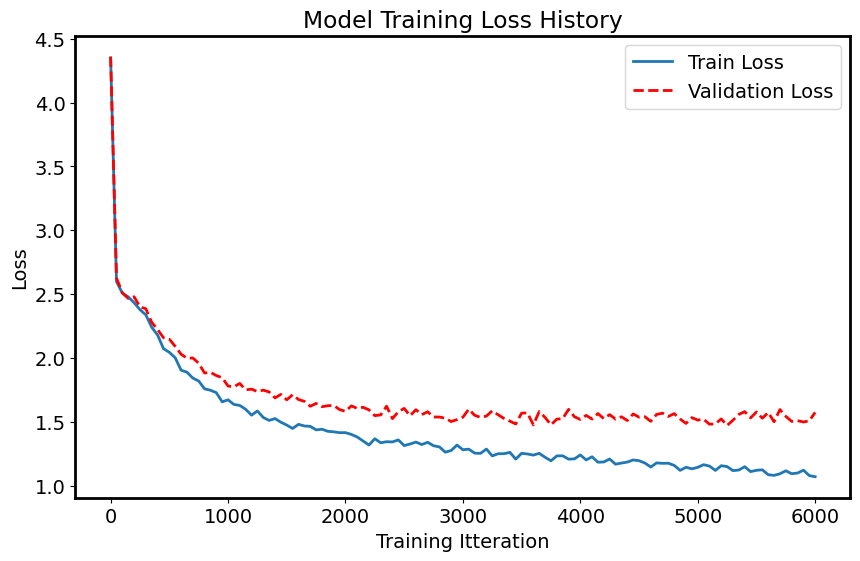

In [14]:
# Plot train and validation loss

test_name = 'base'
plot_title = r"Model Training Loss History"

plt.rcParams.update({'font.size': 14})
plt.rcParams['axes.linewidth']=2
plt.figure(figsize = (10,6))
plt.title(plot_title)
itterations = np.linspace(0, max_iters, int(max_iters/eval_interval)+1)
plt.plot(itterations, loss_train, lw = 2, label='Train Loss')
plt.plot(itterations, loss_validation, 'r--', lw = 2, label='Validation Loss')
plt.legend()
plt.xlabel(r'Training Itteration')
plt.ylabel(r'Loss');
figure_name = f"loss_history_{test_name}.pdf"
plt.savefig(figure_name, format="pdf", bbox_inches='tight')

In [15]:
# Generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device) # Input Context for the generation
tokens_to_predict = 500

# Generate new tokens
model_token_prediction = model.generate_tokens(context, tokens_to_predict)[0].tolist()
text_output = decode(model_token_prediction) # Decode model prediction

# Print model prediction (decoded)
print('### Model Prediction ###\n')
print(text_output)

### Model Prediction ###


even Prince of Spant, and Pierce of France,
Smile all thy chamberlance urged saved trembles
Would grave; with thy proper with safety;
High threaten three flesh thy uild reout,
And cap made a dlain o' the time and
Give Henry gnarlory OF YORK:
Ad never say, yonder conqueit his chamber
May from Edward's land. The untaught on mine prince,
Unto my minstrel lowders-hate thy complotted
Of bapes, of the chief umpost, like a true
Intelligence that present knawlets now thou,
So lossly will ears the peor g


In [ ]:
# Implement language tool

!pip install language-tool-python
import language_tool_python

# Define the language tool
grammar_tool = language_tool_python.LanguageTool('en-US')

# Text to check
input_text = "AThe captanch unical survach ontor the ground."

# Check for grammar errors
matches = grammar_tool.check(text)

# Correct the text
corrected_text = grammar_tool.correct(input_text)
print("Original Text:", input_text)
print("\nNew Text:", corrected_text)